### 1. 데이터 준비 및 확인
IMDB 영화 리뷰 데이터셋을 로드하고, 훈련 데이터와 테스트 데이터의 개수를 확인합니다.

In [1]:
import numpy as np
import torch

data_dir = 'data/'

# lms에 데이터 안보여서 다운받은 파일로 대체 
imdb_data = np.load(data_dir + 'imdb.npz', allow_pickle=True)
x_train, y_train = imdb_data['x_train'], imdb_data['y_train']
x_test, y_test = imdb_data['x_test'], imdb_data['y_test']
print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")

훈련 샘플 개수: 25000, 테스트 개수: 25000


### 2. 데이터 변환 함수 정의
숫자로 인코딩된 문장을 다시 텍스트로, 또는 텍스트를 인코딩된 문장으로 변환하는 헬퍼 함수를 정의합니다.

In [2]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외


### 3. 데이터 샘플 확인
첫 번째 훈련용 리뷰 데이터(숫자 인덱스), 라벨, 그리고 각 리뷰의 길이를 확인하여 데이터의 형태를 파악합니다.

In [3]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[23022, 309, 6, 3, 1069, 209, 9, 2175, 30, 1, 169, 55, 14, 46, 82, 5869, 41, 393, 110, 138, 14, 5359, 58, 4477, 150, 8, 1, 5032, 5948, 482, 69, 5, 261, 12, 23022, 73935, 2003, 6, 73, 2436, 5, 632, 71, 6, 5359, 1, 25279, 5, 2004, 10471, 1, 5941, 1534, 34, 67, 64, 205, 140, 65, 1232, 63526, 21145, 1, 49265, 4, 1, 223, 901, 29, 3024, 69, 4, 1, 5863, 10, 694, 2, 65, 1534, 51, 10, 216, 1, 387, 8, 60, 3, 1472, 3724, 802, 5, 3521, 177, 1, 393, 10, 1238, 14030, 30, 309, 3, 353, 344, 2989, 143, 130, 5, 7804, 28, 4, 126, 5359, 1472, 2375, 5, 23022, 309, 10, 532, 12, 108, 1470, 4, 58, 556, 101, 12, 23022, 309, 6, 227, 4187, 48, 3, 2237, 12, 9, 215]
라벨:  1
1번째 리뷰 문장 길이:  138
2번째 리뷰 문장 길이:  433


### 4. 단어 사전(Vocabulary) 로드
단어와 인덱스 정보를 담고 있는 `imdb_word_index.json` 파일을 로드하여, 단어를 인덱스로 또는 인덱스를 단어로 변환할 수 있는 딕셔너리를 생성합니다.

In [4]:
# 데이터셋 없어서 다운받은 imdb_word_index.json 파일을 읽어옴
word_to_index = open(data_dir + 'imdb_word_index.json', 'r', encoding='utf-8').read()
word_to_index = eval(word_to_index)  # JSON 문자열을 딕셔너리로 변환

index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다.
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


### 5. 인덱스 보정 및 특수 토큰 추가
IMDB 데이터셋의 인덱스는 실제 단어 인덱스에서 3만큼 밀려 있으므로 이를 보정합니다. 또한, 문장의 시작, 끝, 사전에 없는 단어 등을 표시하기 위한 특수 토큰(`<PAD>`, `<BOS>`, `<UNK>`, `<UNUSED>`)을 단어 사전에 추가합니다.

In [5]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.
print(word_to_index['the'])  # 4 이 출력됩니다.
print(index_to_word[4])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

<BOS>
4
the
himself a <UNUSED> considering without is luke be <BOS> find very this out also newman her face seen why this moreover time dub now to <BOS> unpredictable sorely guess had and although it unapologetic classed'' behavior a well source and hero were a moreover <BOS> periodic and captured capshaw <BOS> 1950 proves by see only own go story likes clubfoot columbus <BOS> excerpted the <BOS> family write he mob had the <BOS> lasting br knows <UNK> story proves what br come <BOS> let to even <UNUSED> trailer progress editing and pleased cast <BOS> face br surprisingly speakeasy be himself <UNUSED> try home topic through end and boo have the ever moreover trailer relatively and unapologetic himself br self it films include the time killed any it unapologetic himself a bit goodness if <UNUSED> assume it is must


### 6. 데이터 길이 통계 분석 및 패딩 길이 결정
전체 리뷰 데이터의 길이 분포(평균, 최대, 표준편차)를 분석하여, 모델에 입력할 문장의 최대 길이(`maxlen`)를 결정합니다. 너무 긴 문장은 잘라내고, 짧은 문장은 채워넣기(패딩) 위함입니다.

In [6]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  233.75892
문장길이 최대 :  2493
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  579
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


### 7. 데이터 패딩 및 텐서 변환
결정된 `maxlen`에 맞춰 모든 문장의 길이를 통일하는 패딩(padding) 작업을 수행하고, 데이터를 PyTorch 모델이 사용할 수 있는 텐서(Tensor) 형태로 변환합니다.

In [7]:
def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(x_train, maxlen)
x_test_padded = pad_sequences(x_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([25000, 579])


### 8. LSTM 기반 감성 분석 모델 설계
PyTorch를 사용하여 LSTM(Long Short-Term Memory) 기반의 딥러닝 모델을 설계합니다. 이 모델은 임베딩 레이어, LSTM 레이어, 그리고 두 개의 완전 연결(FC) 레이어로 구성됩니다.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel(vocab_size, word_vector_dim)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


### 9. 훈련/검증 데이터셋 분리
훈련 데이터 중 10,000건을 검증(validation) 데이터로 분리하여 모델 학습 중 성능을 평가하는 데 사용합니다.

In [9]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([15000, 579])
(15000,)


### 10. 모델 훈련 및 검증 (MPS 가속 적용)
모델의 옵티마이저와 손실 함수를 정의하고, 훈련 루프를 실행합니다. Apple Silicon GPU(MPS)를 사용하여 훈련을 가속합니다. 각 에폭마다 훈련 및 검증 손실과 정확도를 출력하여 학습 과정을 모니터링합니다.

In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# MPS 장치 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

# Replace out-of-vocab indices with <UNK> (2)
def replace_oov_indices(arr, vocab_size, unk_idx=2):
    arr = np.where(arr >= vocab_size, unk_idx, arr)
    return arr

partial_x_train_oov = replace_oov_indices(partial_x_train.numpy(), vocab_size)
x_val_oov = replace_oov_indices(x_val.numpy(), vocab_size)

partial_x_train_tensor = torch.tensor(partial_x_train_oov, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val_oov, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 10   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

Using device: mps
Epoch 1/5 - Train Loss: 0.6082, Train Accuracy: 0.8333 - Validation Loss: 0.8702, Validation Accuracy: 0.0000
Epoch 2/5 - Train Loss: 0.5860, Train Accuracy: 0.8333 - Validation Loss: 0.9298, Validation Accuracy: 0.0000
Epoch 3/5 - Train Loss: 0.5570, Train Accuracy: 0.8333 - Validation Loss: 1.0326, Validation Accuracy: 0.0000
Epoch 4/5 - Train Loss: 0.5203, Train Accuracy: 0.8333 - Validation Loss: 1.1757, Validation Accuracy: 0.0000
Epoch 5/5 - Train Loss: 0.4899, Train Accuracy: 0.8333 - Validation Loss: 1.3425, Validation Accuracy: 0.0000


### 11. 테스트셋으로 모델 최종 평가
학습이 완료된 모델을 사용하여, 한 번도 보지 않은 테스트 데이터셋으로 최종 성능(손실 및 정확도)을 평가합니다.

In [11]:
test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Replace out-of-vocab indices with <UNK> (2) before passing to model
        inputs = torch.where(inputs >= vocab_size, torch.tensor(2, dtype=inputs.dtype, device=device), inputs)
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.8217, Test Accuracy: 0.5000


### 12. 훈련 과정 시각화 (손실)
Matplotlib을 사용하여 에폭별 훈련 손실(Training Loss)과 검증 손실(Validation Loss)의 변화를 그래프로 시각화합니다. 이를 통해 모델의 과적합 여부를 확인할 수 있습니다.

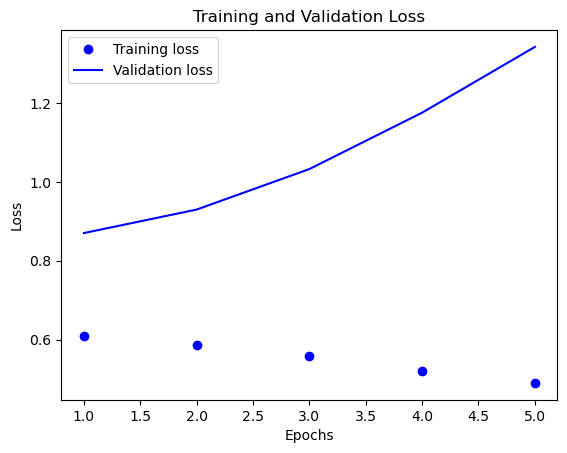

In [12]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 13. 훈련 과정 시각화 (정확도)
에폭별 훈련 정확도(Training Accuracy)와 검증 정확도(Validation Accuracy)의 변화를 그래프로 시각화하여, 모델이 얼마나 잘 학습되고 있는지 확인합니다.

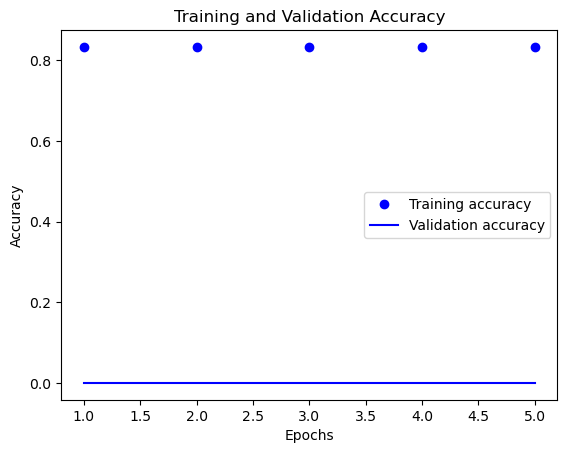

In [13]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 14. 사전 훈련된 Word2Vec 임베딩 활용
모델의 성능을 높이기 위해, Google News 데이터셋으로 미리 훈련된 Word2Vec 모델을 로드합니다. 이 모델은 단어를 의미적으로 유사한 벡터로 변환하는 능력을 가지고 있습니다.

In [14]:
from gensim.models import KeyedVectors

word2vec_path = data_dir + 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

### 15. Word2Vec 유사도 테스트
로드한 Word2Vec 모델을 사용하여 "love"와 가장 유사한 단어들을 확인해 봅니다.

In [15]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816874146461487),
 ('loves', 0.6618633270263672),
 ('passion', 0.6100709438323975),
 ('hate', 0.6003956198692322),
 ('loving', 0.5886634588241577),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547305345535278),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

### 16. Word2Vec 임베딩 행렬 생성
우리의 단어 사전을 기준으로, 사전 훈련된 Word2Vec 벡터들을 복사하여 임베딩 행렬을 생성합니다. 이 행렬은 새로운 모델의 임베딩 레이어 가중치로 사용됩니다.

In [16]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [17]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# MPS 장치 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

model.to(device)

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

# Replace out-of-vocab indices with <UNK> (2)
def replace_oov_indices(arr, vocab_size, unk_idx=2):
    arr = np.where(arr >= vocab_size, unk_idx, arr)
    return arr

partial_x_train_oov = replace_oov_indices(partial_x_train.numpy(), vocab_size)
x_val_oov = replace_oov_indices(x_val.numpy(), vocab_size)

partial_x_train_tensor = torch.tensor(partial_x_train_oov, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val_oov, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 20   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

Using device: mps
Epoch 1/20 - Train Loss: 0.4672, Train Accuracy: 0.8333 - Validation Loss: 1.4885, Validation Accuracy: 0.0000
Epoch 2/20 - Train Loss: 0.4567, Train Accuracy: 0.8333 - Validation Loss: 1.6272, Validation Accuracy: 0.0000
Epoch 3/20 - Train Loss: 0.4530, Train Accuracy: 0.8333 - Validation Loss: 1.7351, Validation Accuracy: 0.0000
Epoch 4/20 - Train Loss: 0.4511, Train Accuracy: 0.8333 - Validation Loss: 1.7735, Validation Accuracy: 0.0000
Epoch 5/20 - Train Loss: 0.4497, Train Accuracy: 0.8333 - Validation Loss: 1.7813, Validation Accuracy: 0.0000
Epoch 6/20 - Train Loss: 0.4512, Train Accuracy: 0.8333 - Validation Loss: 1.7813, Validation Accuracy: 0.0000
Epoch 7/20 - Train Loss: 0.4488, Train Accuracy: 0.8333 - Validation Loss: 1.7815, Validation Accuracy: 0.0000
Epoch 8/20 - Train Loss: 0.4476, Train Accuracy: 0.8333 - Validation Loss: 1.7929, Validation Accuracy: 0.0000
Epoch 9/20 - Train Loss: 0.4470, Train Accuracy: 0.8333 - Validation Loss: 1.7871, Validation 

In [20]:
# 테스트셋을 통한 모델 평가
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

# 이미 x_test_tensor와 y_test는 이전 셀에서 정의되어 있습니다.
test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 1.0180, Test Accuracy: 0.5000


### 17. 1D-CNN 기반 새로운 모델 설계
1D Convolutional Neural Network(CNN)를 기반으로 한 새로운 감성 분석 모델을 설계합니다. 이 모델은 Word2Vec으로 초기화된 임베딩 레이어를 사용하며, 두 개의 Conv1D 레이어와 두 개의 FC 레이어로 구성됩니다.

In [21]:
class SentimentModelCNN(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModelCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.global_max_pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model_cnn = SentimentModelCNN(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model_cnn)

SentimentModelCNN(
  (embedding): Embedding(10000, 300)
  (conv1): Conv1d(300, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


### 18. 1D-CNN 모델 훈련 및 검증 (MPS 가속 적용)
새로운 1D-CNN 모델의 훈련을 시작합니다. 이전과 동일하게 MPS 가속을 적용하여 효율적으로 학습을 진행합니다.

In [22]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

model_cnn.to(device) # 모델을 MPS 장치로 이동

optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

# 학습의 진행
epochs = 10    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses_cnn = []
val_losses_cnn = []
train_accs_cnn = []
val_accs_cnn = []

for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # 데이터도 MPS 장치로 이동
        optimizer.zero_grad()

        # 입력 데이터의 인덱스가 vocab_size(10000) 이상이면 <UNK>(2)로 치환
        inputs = torch.where(inputs >= vocab_size, torch.tensor(2, dtype=inputs.dtype, device=device), inputs)
        outputs = model_cnn(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses_cnn.append(running_loss / len(train_loader))
    train_accs_cnn.append(correct / total)

    model_cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # 데이터도 MPS 장치로 이동
            outputs = model_cnn(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses_cnn.append(val_loss / len(val_loader))
    val_accs_cnn.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses_cnn[-1]:.4f}, Train Accuracy: {train_accs_cnn[-1]:.4f} - "
          f"Validation Loss: {val_losses_cnn[-1]:.4f}, Validation Accuracy: {val_accs_cnn[-1]:.4f}")

Epoch 1/10 - Train Loss: 0.4854, Train Accuracy: 0.8333 - Validation Loss: 1.6254, Validation Accuracy: 0.0000
Epoch 2/10 - Train Loss: 0.4493, Train Accuracy: 0.8333 - Validation Loss: 1.7178, Validation Accuracy: 0.0000
Epoch 3/10 - Train Loss: 0.4509, Train Accuracy: 0.8333 - Validation Loss: 1.8050, Validation Accuracy: 0.0000
Epoch 4/10 - Train Loss: 0.4448, Train Accuracy: 0.8333 - Validation Loss: 1.7783, Validation Accuracy: 0.0000
Epoch 5/10 - Train Loss: 0.4393, Train Accuracy: 0.8333 - Validation Loss: 1.7569, Validation Accuracy: 0.0000
Epoch 6/10 - Train Loss: 0.4027, Train Accuracy: 0.8333 - Validation Loss: 1.5387, Validation Accuracy: 0.0158
Epoch 7/10 - Train Loss: 0.3280, Train Accuracy: 0.8574 - Validation Loss: 1.4813, Validation Accuracy: 0.1974
Epoch 8/10 - Train Loss: 0.2640, Train Accuracy: 0.8902 - Validation Loss: 1.5889, Validation Accuracy: 0.2523
Epoch 9/10 - Train Loss: 0.2057, Train Accuracy: 0.9190 - Validation Loss: 1.4268, Validation Accuracy: 0.3876
E

### 19. 1D-CNN 모델 최종 평가
학습된 1D-CNN 모델의 최종 성능을 테스트셋으로 평가합니다.

In [23]:
# 테스트셋을 통한 모델 평가
model_cnn.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) # 데이터도 MPS 장치로 이동
        outputs = model_cnn(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Test Loss: 0.8621, Test Accuracy: 0.6810
